In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import scikitplot as skplt
import scipy as sp
import statsmodels as st

In [2]:
from sklearn.datasets import load_iris

In [3]:
X, y = load_iris(return_X_y=True)

# How to use our machine learning

## Explanation

We want our model to have the best score, and to gain a higher score, we must :
- Avoid overfitting (Regularization, Cross Validation)
- Avoid underfitting (Get enough diversity in our data)

To accomplish our goal, we should :
- Make some Feature Engineering with an EDA
- Choose metrics for our model
- Split our data
- Make a pipeline
- Make a grid search
- plot a confusion matrix


In [4]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
dim_list = ["sepal length in cm", "sepal width in cm", "petal length in cm", "petal width in cm"]
for it,dim in enumerate(dim_list):
    vif = variance_inflation_factor(X, it)
    print(f"Vif de {dim} \t: {vif}")

Vif de sepal length in cm 	: 262.9693482414677
Vif de sepal width in cm 	: 96.35329172369063
Vif de petal length in cm 	: 172.96096155387588
Vif de petal width in cm 	: 55.50205979323753


Variables have a high collinearity with the explanatory variables, and our model should have a large standard error because of this. One solution could be to use Ridge Regression because it’s robust to multicolinearity.

## K-Means clustering

We want to evaluate how good is the clustering with k-Means, for which we choose 3 clusters.

In [5]:
from sklearn import cluster
k_means = cluster.KMeans(n_clusters=3)
k_means.fit(X)
pd.Series(k_means.labels_==y).value_counts()

False    114
True      36
dtype: int64

## Computing of silhouette coefficient
The silhouette Coefficient is calculate using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coeffecient for a sample is (b-a) / max(a, b).

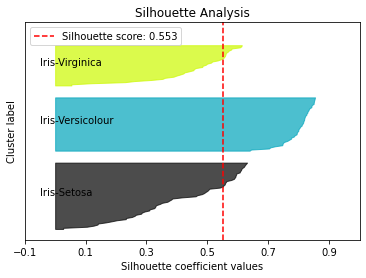

In [6]:
labels = pd.Series(k_means.labels_)\
        .map({0 : "Iris-Setosa", 1: "Iris-Versicolour", 2: "Iris-Virginica"}).to_numpy()
skplt.metrics.plot_silhouette(X, labels, 
                              title="Silhouette Analysis")                      
plt.show()

## Computing of davies bouldin score

The score is defined as the average similarity measure of each cluster with ts most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances. Thus, clusters which are farther apart and less dispersed will result in a better score. The minimum score is zero. The lower values indicating better clustering.

In [7]:
from sklearn.metrics import davies_bouldin_score

In [8]:
davies_bouldin_score(X, k_means.labels_)

0.6619715465007465

## Make two models Ridge and Random Forest

### Ridge

In [31]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, RidgeClassifier
from sklearn.preprocessing import StandardScaler

We want to take a piece of data apart for testing operation with our model. We take 20% of our dataset that won’t serve for training.

In [23]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In our reflexion to choose the best alpha coefficient, we’ve decided to plot a regular combinaison of alpha for each features. We’ve normalized our data as usual in regularization, cause they need it.

On the plot we see that a good number for alpha is beetween 50 and 10.

In [24]:
X_norm = StandardScaler().fit(X_train).transform(X_train)

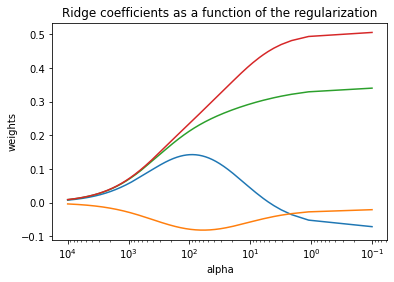

In [25]:
alphas = [x/10 for x in range(1,10**5, 10)]
coefs = []
for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X_norm, y_train)
    coefs.append(ridge.coef_)
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

Now we want to make a grid search with a pipeline to discover the right answer for our alpha coefficient. We’ve based our focus on the score of the negative mean squared error. And we add an utilization of Cross Validation, that we’ll plot below to see the curve of learning.

In [37]:
# define the estimator
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", RidgeClassifier())]
)

parameters = {'ridge__alpha': (50, 40, 30, 20, 10)}

# define the grid search
grid_search = GridSearchCV(pipeline, parameters, scoring='neg_mean_squared_error', cv=5)

# fit the grid search
grid_search.fit(X_train, y_train)

# get the best parameters
best_parameters = grid_search.best_estimator_.get_params()


In [38]:
# best estimator
print(grid_search.best_estimator_)

# best model
best_model = grid_search.best_estimator_
#best_model.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', RidgeClassifier(alpha=20))])


<AxesSubplot:title={'center':'Learning Curve'}, xlabel='Training examples', ylabel='Score'>

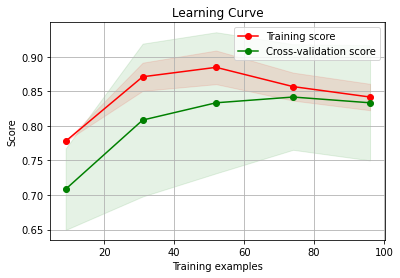

In [39]:
# How the model learn regarding the cross validation.
skplt.estimators.plot_learning_curve(best_model, X_train, y_train)

Now that we’ve got the model, we can test how he performs on unseen data. We’ve chosen a confusion matrix for multiclasse purposes.

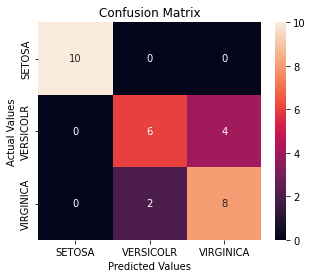

In [40]:
from sklearn.metrics import confusion_matrix
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['SETOSA','VERSICOLR','VIRGINICA'], 
                     columns = ['SETOSA','VERSICOLR','VIRGINICA'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

The performance of our model is printed in this table. We see that for two classes Versicolr and Virginica there is a worst prediction. 

In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['SETOSA','VERSICOLR','VIRGINICA']))


              precision    recall  f1-score   support

      SETOSA       1.00      1.00      1.00        10
   VERSICOLR       0.75      0.60      0.67        10
   VIRGINICA       0.67      0.80      0.73        10

    accuracy                           0.80        30
   macro avg       0.81      0.80      0.80        30
weighted avg       0.81      0.80      0.80        30



### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [50]:
# define the estimator
pipeline = Pipeline([
    ("random_forest", RandomForestClassifier())]
)
parameters = {'random_forest__criterion': ("gini", "entropy", "log_loss")}

# define the grid search
grid_search = GridSearchCV(pipeline, parameters, scoring='neg_mean_squared_error', cv=3)

# fit the grid search
grid_search.fit(X_train, y_train)

# get the best parameters
best_parameters = grid_search.best_estimator_.get_params()


In [51]:
# best estimator
print(grid_search.best_estimator_)

# best model
best_model = grid_search.best_estimator_
#best_model.fit(X_train,y_train)

Pipeline(steps=[('random_forest', RandomForestClassifier())])


<AxesSubplot:title={'center':'Learning Curve'}, xlabel='Training examples', ylabel='Score'>

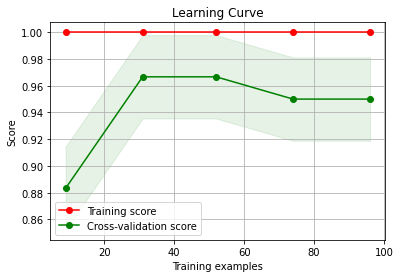

In [52]:
# How the model learn regarding the cross validation.
skplt.estimators.plot_learning_curve(best_model, X_train, y_train)

Now that we’ve got the RandomForest model, we can test how it performs on unseen data. We’ve chosen a confusion matrix for multiclasse purposes.

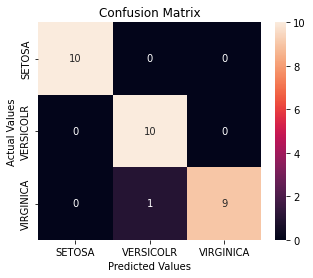

In [53]:
from sklearn.metrics import confusion_matrix
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['SETOSA','VERSICOLR','VIRGINICA'], 
                     columns = ['SETOSA','VERSICOLR','VIRGINICA'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

This model outperformed the last one. He has a high performance and can predict correctly which class

In [54]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['SETOSA','VERSICOLR','VIRGINICA']))


              precision    recall  f1-score   support

      SETOSA       1.00      1.00      1.00        10
   VERSICOLR       0.91      1.00      0.95        10
   VIRGINICA       1.00      0.90      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

